# Liver Model Construction: Notebook-Glycogenolysis

## Setup workflow

### Import packages

In [1]:
import os
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

MASSpy version: 0.1.1


## Set paths and constants

In [2]:
seed = int(4)
#increase number of models from before
n_models = 20

mass_config = MassConfiguration()
mass_config.solver = "cplex"

### Directory paths

In [3]:
#had to remove the mass
model_dir = os.path.abspath("/Users/RiyaMathur/MASSliver/models")
maps_dir = os.path.abspath("/Users/RiyaMathur/MASSliver/models/maps")
data_dir = os.path.abspath("/Users/RiyaMathur/Downloads")

#model_dir = os.path.abspath("../mass_user/models")
#maps_dir = os.path.abspath("../mass_user/maps")
#data_dir = os.path.abspath("../mass_user/data")

In [4]:
# Allow Escher to close without pop-up
escher.rc['never_ask_before_quit'] = True


### Load COBRA model

In [5]:
core_model=load_json_cobra_model(filename=os.path.join(model_dir,"CoreModel.json"))
core_model

Name,None
Memory address,0x07f8dab30d490
Number of metabolites,178
Number of reactions,187
Number of groups,0
Objective expression,1.0*ATPM - 1.0*ATPM_reverse_5b752
Compartments,"m, i, c, r,"


In [6]:
# core_model.remove_reactions(EX_glc__D_c)

In [7]:
# core_model.remove_reactions([EX_glc__D_c])

In [8]:
core_model.boundary

[<Reaction EX_h_c at 0x7f8db4636e80>,
 <Reaction EX_pyr_c at 0x7f8db46364c0>,
 <Reaction EX_h2o_c at 0x7f8db463d6a0>,
 <Reaction EX_pi_c at 0x7f8db463d7c0>,
 <Reaction EX_glc__D_c at 0x7f8db463d880>,
 <Reaction EX_lac__L_c at 0x7f8db463d940>,
 <Reaction EX_co2_c at 0x7f8db463da00>,
 <Reaction EX_o2_c at 0x7f8db463dac0>,
 <Reaction EX_octa_prod_c at 0x7f8db463db80>,
 <Reaction EX_octa_cons_c at 0x7f8db463dc40>,
 <Reaction EX_urea_c at 0x7f8db463ddc0>,
 <Reaction EX_gln__L_c at 0x7f8db463de80>,
 <Reaction EX_acetone_c at 0x7f8db463dd00>,
 <Reaction EX_bhb_c at 0x7f8db463df40>,
 <Reaction EX_glu__L_c at 0x7f8db463d1c0>,
 <Reaction EX_ser__L_c at 0x7f8db463d3a0>,
 <Reaction EX_cys__L_c at 0x7f8db45c6100>,
 <Reaction EX_gly_c at 0x7f8db45c6280>,
 <Reaction EX_glygn2_c at 0x7f8db45c6340>,
 <Reaction EX_Tyr_ggn_c at 0x7f8db45c6400>,
 <Reaction EX_ala__L_c at 0x7f8db45c64c0>,
 <Reaction EX_nh4_c at 0x7f8db45c6580>,
 <Reaction EX_so3_c at 0x7f8db45c6640>,
 <Reaction EX_etoh_c at 0x7f8db45c6700>

In [9]:
## adding reactions from Recon3D
R3D=load_json_cobra_model(filename=os.path.join(model_dir,"Recon3D.json"))

In [10]:
## adding reactions from glycogenloysis 
gly=load_json_cobra_model(filename=os.path.join(model_dir,"Glycogenolysis.json"))

In [11]:
## change after double checking this, maybe not needed to be added to core?
a= R3D.reactions.EX_glc__D_e
b= R3D.reactions.GLCt1
g= gly.reactions.SK_g6p_c
new_r_list=[
            a,
            b,
            g
    
]


In [12]:
for x in new_r_list:
    c= x
    core_model.add_reaction(c)

In [13]:
core_model.reactions

[<Reaction CSm at 0x7f8db42deb20>,
 <Reaction ACONTm at 0x7f8db42deb50>,
 <Reaction ICDHxm at 0x7f8db42debb0>,
 <Reaction AKGDm at 0x7f8db42deb80>,
 <Reaction SUCOASm at 0x7f8db42debe0>,
 <Reaction SUCD1m at 0x7f8db42defa0>,
 <Reaction FUMm at 0x7f8db42ebdf0>,
 <Reaction MDHm at 0x7f8db42ebb50>,
 <Reaction NADH2_u10mi at 0x7f8db42eb190>,
 <Reaction FADH2ETC at 0x7f8db42eb970>,
 <Reaction CYOR_u10mi at 0x7f8db43110d0>,
 <Reaction CYOOm2i at 0x7f8db42f5700>,
 <Reaction ATPS4mi at 0x7f8db42f53d0>,
 <Reaction Htmi at 0x7f8db42f5340>,
 <Reaction HEX1 at 0x7f8db42f5af0>,
 <Reaction PGI at 0x7f8db42f5d90>,
 <Reaction PFK at 0x7f8db4311eb0>,
 <Reaction FBA at 0x7f8db4311a30>,
 <Reaction TPI at 0x7f8db42fc6d0>,
 <Reaction GAPD at 0x7f8db42fc9a0>,
 <Reaction PGK at 0x7f8db42fcfa0>,
 <Reaction PGM at 0x7f8db45bbee0>,
 <Reaction ENO at 0x7f8db45bbf70>,
 <Reaction PYK at 0x7f8db4304af0>,
 <Reaction ADK1 at 0x7f8db4304d60>,
 <Reaction PDHm at 0x7f8db4304880>,
 <Reaction LDH_L at 0x7f8db4304580>,
 <R

## View Escher map

In [14]:
#view all the reactions that we need build
escher_builder = escher.Builder(
    model=core_model,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycogenolysis", "map", "json"))
    ),
    highlight_missing=True)

escher_builder


Builder(highlight_missing=True, never_ask_before_quit=True)

### Loading Measured Fluxes

In [15]:
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [16]:
#define data sheet as latest data sheet
data_sheet=os.path.join(data_dir,"1.12-ma-rm-QPdata-collection-glycogenolysis.xlsx")

flux_df = load_data(
    filepath=data_sheet,
    sheet_name="Fluxes").drop("Fasting Time", axis=1).drop("Additional Notes", axis=1).drop("Unnamed: 4", axis=1).drop("Unnamed: 5", axis=1)
    ## weird anomaly, shouldn't happen * unnames:4 and 5

flux_df = flux_df.dropna() #drops rows with NaN
flux_df


,Flux (mmol/gDW*hr)
ID,
GLCter,-0.001682
G6PPer,0.001682
G6Pter,0.001682
EX_glc__D_e,0.001682
GLCt1,-0.001682


In [17]:
v_vars = []
v_data = []

# How much flux to allow through irreversible reaction pairs
# e.g, PFK/FBP & reverse_flux_percent = 0.1, raise both fluxes by 10% of non-zero flux value
reverse_flux_percent = 0.1
irreversible_enzyme_pairs = ["PFK", "FBP"]

In [18]:
core_model.reactions

[<Reaction CSm at 0x7f8db42deb20>,
 <Reaction ACONTm at 0x7f8db42deb50>,
 <Reaction ICDHxm at 0x7f8db42debb0>,
 <Reaction AKGDm at 0x7f8db42deb80>,
 <Reaction SUCOASm at 0x7f8db42debe0>,
 <Reaction SUCD1m at 0x7f8db42defa0>,
 <Reaction FUMm at 0x7f8db42ebdf0>,
 <Reaction MDHm at 0x7f8db42ebb50>,
 <Reaction NADH2_u10mi at 0x7f8db42eb190>,
 <Reaction FADH2ETC at 0x7f8db42eb970>,
 <Reaction CYOR_u10mi at 0x7f8db43110d0>,
 <Reaction CYOOm2i at 0x7f8db42f5700>,
 <Reaction ATPS4mi at 0x7f8db42f53d0>,
 <Reaction Htmi at 0x7f8db42f5340>,
 <Reaction HEX1 at 0x7f8db42f5af0>,
 <Reaction PGI at 0x7f8db42f5d90>,
 <Reaction PFK at 0x7f8db4311eb0>,
 <Reaction FBA at 0x7f8db4311a30>,
 <Reaction TPI at 0x7f8db42fc6d0>,
 <Reaction GAPD at 0x7f8db42fc9a0>,
 <Reaction PGK at 0x7f8db42fcfa0>,
 <Reaction PGM at 0x7f8db45bbee0>,
 <Reaction ENO at 0x7f8db45bbf70>,
 <Reaction PYK at 0x7f8db4304af0>,
 <Reaction ADK1 at 0x7f8db4304d60>,
 <Reaction PDHm at 0x7f8db4304880>,
 <Reaction LDH_L at 0x7f8db4304580>,
 <R

In [19]:
for rid, flux in flux_df.itertuples():
    reaction = core_model.reactions.get_by_id(rid)
    print(reaction)

GLCter: glc__D_c <=> glc__D_r
G6PPer: g6p_r + h2o_r --> glc__D_r + pi_r
G6Pter: g6p_c <=> g6p_r
EX_glc__D_e: glc__D_e <=> 
GLCt1: glc__D_e <=> glc__D_c


In [20]:
core_model.reactions

[<Reaction CSm at 0x7f8db42deb20>,
 <Reaction ACONTm at 0x7f8db42deb50>,
 <Reaction ICDHxm at 0x7f8db42debb0>,
 <Reaction AKGDm at 0x7f8db42deb80>,
 <Reaction SUCOASm at 0x7f8db42debe0>,
 <Reaction SUCD1m at 0x7f8db42defa0>,
 <Reaction FUMm at 0x7f8db42ebdf0>,
 <Reaction MDHm at 0x7f8db42ebb50>,
 <Reaction NADH2_u10mi at 0x7f8db42eb190>,
 <Reaction FADH2ETC at 0x7f8db42eb970>,
 <Reaction CYOR_u10mi at 0x7f8db43110d0>,
 <Reaction CYOOm2i at 0x7f8db42f5700>,
 <Reaction ATPS4mi at 0x7f8db42f53d0>,
 <Reaction Htmi at 0x7f8db42f5340>,
 <Reaction HEX1 at 0x7f8db42f5af0>,
 <Reaction PGI at 0x7f8db42f5d90>,
 <Reaction PFK at 0x7f8db4311eb0>,
 <Reaction FBA at 0x7f8db4311a30>,
 <Reaction TPI at 0x7f8db42fc6d0>,
 <Reaction GAPD at 0x7f8db42fc9a0>,
 <Reaction PGK at 0x7f8db42fcfa0>,
 <Reaction PGM at 0x7f8db45bbee0>,
 <Reaction ENO at 0x7f8db45bbf70>,
 <Reaction PYK at 0x7f8db4304af0>,
 <Reaction ADK1 at 0x7f8db4304d60>,
 <Reaction PDHm at 0x7f8db4304880>,
 <Reaction LDH_L at 0x7f8db4304580>,
 <R

In [21]:
for rid, flux in flux_df.itertuples():
    reaction = core_model.reactions.get_by_id(rid)
    #reaction.bounds = (flux, flux)
    #set bounds for all boundary reactions 
    #uptake --> (-value, 1000)
    #secretion --> (-1000 --> value)
    #reversible --> (-1000,1000)
    if (rid == "EX_lac__L_c"): #uptake
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (0,1000) 
    elif (rid == "EX_glc__L_e"): #secretion
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (-1000, 0) 
    elif (rid == "EX_pyr_c"): #uptake
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (0, 1000) 
    elif (rid == "EX_glygn2_c"): #uptake
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (-1, 1000) 
    for irreversible_enzyme_pair in irreversible_enzyme_pairs:
        if rid in irreversible_enzyme_pair:
            flux1, flux2 = flux_df.loc[irreversible_enzyme_pairs, "Flux(mmol/(gDW*hr))"].values
            if flux1 == 0:
                flux += reverse_flux_percent * flux2 # mmol*gDW^-1*hr^-1
            if flux2 == 0:
                flux += reverse_flux_percent * flux1 # mmol*gDW^-1*hr^-1
   
    #address irreversible enzyme pair boundary reactions if necessary

    print(rid, flux)

    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)
    
#print(v_vars)
#print(v_data)


GLCter -0.001682007621
G6PPer 0.001682007621
G6Pter 0.001682007621
EX_glc__D_e 0.001682007621
GLCt1 -0.001682007621


In [22]:
core_model.reactions

[<Reaction CSm at 0x7f8db42deb20>,
 <Reaction ACONTm at 0x7f8db42deb50>,
 <Reaction ICDHxm at 0x7f8db42debb0>,
 <Reaction AKGDm at 0x7f8db42deb80>,
 <Reaction SUCOASm at 0x7f8db42debe0>,
 <Reaction SUCD1m at 0x7f8db42defa0>,
 <Reaction FUMm at 0x7f8db42ebdf0>,
 <Reaction MDHm at 0x7f8db42ebb50>,
 <Reaction NADH2_u10mi at 0x7f8db42eb190>,
 <Reaction FADH2ETC at 0x7f8db42eb970>,
 <Reaction CYOR_u10mi at 0x7f8db43110d0>,
 <Reaction CYOOm2i at 0x7f8db42f5700>,
 <Reaction ATPS4mi at 0x7f8db42f53d0>,
 <Reaction Htmi at 0x7f8db42f5340>,
 <Reaction HEX1 at 0x7f8db42f5af0>,
 <Reaction PGI at 0x7f8db42f5d90>,
 <Reaction PFK at 0x7f8db4311eb0>,
 <Reaction FBA at 0x7f8db4311a30>,
 <Reaction TPI at 0x7f8db42fc6d0>,
 <Reaction GAPD at 0x7f8db42fc9a0>,
 <Reaction PGK at 0x7f8db42fcfa0>,
 <Reaction PGM at 0x7f8db45bbee0>,
 <Reaction ENO at 0x7f8db45bbf70>,
 <Reaction PYK at 0x7f8db4304af0>,
 <Reaction ADK1 at 0x7f8db4304d60>,
 <Reaction PDHm at 0x7f8db4304880>,
 <Reaction LDH_L at 0x7f8db4304580>,
 <R

In [23]:
# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)

F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
core_model.objective = objective[0]
core_model.objective_direction = "min"

flux_solution = core_model.optimize()

In [24]:
flux_solution

,fluxes,reduced_costs
CSm,0.000000,0.000000
ACONTm,0.000000,0.000000
ICDHxm,0.000000,0.000000
AKGDm,0.000000,0.000000
SUCOASm,0.000000,0.000000
...,...,...
EX_glyc_3octa_c,-0.000000,0.000000
EX_fru_c,-0.000000,0.000000
EX_glc__D_e,0.001682,0.000000
GLCt1,-0.001682,0.003364


In [25]:
flux_solution.fluxes

CSm                0.000000
ACONTm             0.000000
ICDHxm             0.000000
AKGDm              0.000000
SUCOASm            0.000000
                     ...   
EX_glyc_3octa_c   -0.000000
EX_fru_c          -0.000000
EX_glc__D_e        0.001682
GLCt1             -0.001682
SK_g6p_c          -0.001682
Name: fluxes, Length: 190, dtype: float64

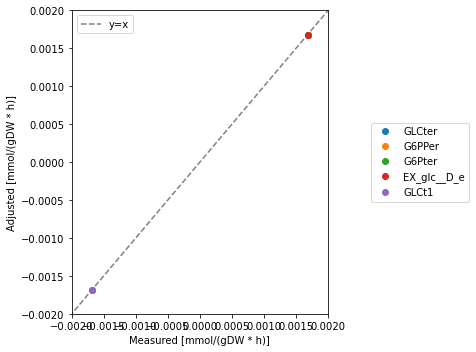

In [26]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_df["Flux (mmol/gDW*hr)"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.002,0.002), ylim=(-0.002, 0.002),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()
#check directionality 


## Create MASS model

In [27]:
glycogenolysis = MassModel("Glycogenolysis", array_type='DataFrame', dtype=np.int64)
glycogenolysis

Name,Glycogenolysis
Memory address,0x07f8db54e6550
Stoichiometric Matrix,0x0
Matrix Rank,0
Number of metabolites,0
Initial conditions defined,0/0
Number of reactions,0
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Define reactions

In [30]:
#add reactions one at a time
reaction_list=[]
reaction_list = ['HEX1',
                 'GLCt1',
                  'G6Pter',
                  'G6PPer',
                 'GLCter'
#                 #'PGI',
#                 #'FBP',
#                 'PFK',
#                 'FBA',
#                 'TPI',
#                 'GAPD',
#                 'PGK',
#                 'PGM',
#                 'ENO',
#                 #'PEPtm',
#                 #'PEPCKm',
#                 #'LDH_L',
#                 'PYK'
#                 #'PCm',
#                 #'PYRt2m'
                ]

# a= R3D.reactions.EX_glc__D_e
# b= R3D.reactions.GLCt1
# g= gly.reactions.SK_g6p_c
# new_r_list=[
#             a,
#             b,
#             g
    
# ]


In [32]:
# Convert cobra.Reactions to mass.MassReactions
for rid in reaction_list:
    reaction = core_model.reactions.get_by_id(rid)
    glycogenolysis.add_reactions([MassReaction(reaction)])

In [33]:
glycogenolysis.reactions.GLCt1

Reaction identifier,GLCt1
Name,Glucose transport uniport
Memory address,0x07f8db55afca0
Subsystem,"Transport, extracellular"
Kinetic Reversibility,True
Stoichiometry,glc__D_e <=> glc__D_c D-Glucose <=> D-Glucose
GPR,66035_AT1 or 6517_AT1 or 56606_AT1 or 154091_AT1 or 6513_AT1 or 11182_AT1 or 29988_AT1 or 6514_AT1 or 155184_AT1 or 56606_AT2 or 144195_AT1 or 6515_AT1 or 81031_AT1
Bounds,"(-1000.0, 1000.0)"


In [ ]:
# for x in new_r_list:
#     c= x
#     core_model.add_reaction(c)

##  Set Fluxes

In [34]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = glycogenolysis.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 / 1000 
    # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 0.0
v_GLCt1: -0.002150623354248705
v_G6Pter: 0.002150623354248705
v_G6PPer: 0.002150623354248705
v_GLCter: -0.002150623354248705


## Set Keqs

In [35]:
# Load equilibrium constants
Keq_df = pd.read_excel(engine='openpyxl',
    io=data_sheet,
    sheet_name="Keqs",
    index_col=0).drop("Reference", axis=1).drop("Stoichiometry", axis=1).drop('Keq unit', axis=1)

Keq_df = Keq_df.dropna() #drops rows with NaN
Keq_df

Keq_df
#Check the M units of Keq 



,Equlibrium Constant
Reaction,
GLCt1,1.000000
HEX1,3000.000000
G6PPer,41.300000
G6Pter,2.761096
GLCter,1.000000


In [36]:
Keq_list =[]
for rid, Keq in Keq_df.itertuples():
    if rid in reaction_list: 
        reaction = glycogenolysis.reactions.get_by_id(rid)
        reaction.Keq = Keq
        Keq_list.append(reaction.Keq)
        print("{0}: {1}".format(reaction.Keq_str, Keq))

Keq_GLCt1: 1.0
Keq_HEX1: 3000.0
Keq_G6PPer: 41.3
Keq_G6Pter: 2.761096464
Keq_GLCter: 1.0


## Set H2O/H Constants

In [37]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
#     "h2o_c",
    "h_c",
#    "glc__D_e",
#     'h20_r'
    
       #'h_i'
       #'h_m' 
    #remove h_i and h_m if not mitochondrial reactions
                  ]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

## Obtain Concentrations

In [38]:
#Load Concentration Data
conc_df = load_data(
    filepath=data_sheet,
    sheet_name="Concentrations").drop("Concentration (mM)", axis=1)
#conc_df = conc_df.drop("Name", axis=1)
conc_df = conc_df.drop("Additional Notes", axis=1)
conc_df = conc_df.dropna() #drops rows with NaN
conc_df

,Name,Concentration(M)
ID,,
glc__D_c,D-Glucose,0.010483
atp_c,ATP C10H12N5O13P3,0.004727
adp_c,ADP C10H12N5O10P2,0.001995
g6p_c,D-Glucose 6-phosphate,0.000140
g6p_r,D-Glucose 6-phosphate,0.000387
pi_r,Phosphate,0.009744


In [39]:
#Set Concentrations

metabolite_list = [
# HEX1    
    'glc__D_c',
    'g6p_c',
    'adp_c',
    'atp_c',
    #'pi_c',
    'h_c',

    'glc__D_e'
    # GLCt1
# #G6Pter
#             'g6p_r',
# #G6PPer 
#             'h2o_r',
#             'glc__D_r',
#             'pi_r'
            
                  ]

In [40]:
met_list = []
for mid, name, conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = glycogenolysis.metabolites.get_by_id(mid)
        metabolite.name = name
        
        metabolite.ic = conc #data sheet is in M units
        met_list.append(metabolite.ic)

In [41]:
glycogenolysis.metabolites

[<MassMetabolite adp_c at 0x7f8db55afe20>,
 <MassMetabolite atp_c at 0x7f8db55afdf0>,
 <MassMetabolite g6p_c at 0x7f8db55afe50>,
 <MassMetabolite glc__D_c at 0x7f8db55afaf0>,
 <MassMetabolite h_c at 0x7f8db55afd00>,
 <MassMetabolite glc__D_e at 0x7f8db55af4f0>,
 <MassMetabolite g6p_r at 0x7f8d9875e880>,
 <MassMetabolite glc__D_r at 0x7f8d9875eac0>,
 <MassMetabolite h2o_r at 0x7f8d9875ecd0>,
 <MassMetabolite pi_r at 0x7f8d9875eca0>]

In [42]:
for metabolite in [
    #'h_i',
    #'h_m',
    "h_c", 
    #"h2o_c"
#'h20_r'
]:
    metabolite = glycogenolysis.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M
    
glycogenolysis.metabolites.glc__D_e.ic= glycogenolysis.metabolites.glc__D_c.ic

for metabolite in glycogenolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 0.00199495195
atp_c: 0.004727145980000001
g6p_c: 0.00014000000000000001
glc__D_c: 0.01048280703
h_c: 1
glc__D_e: 0.01048280703
g6p_r: None
glc__D_r: None
h2o_r: None
pi_r: None


In [43]:
#Formulate QP minimization list for concentrations
## double check this?
conc_solver = ConcSolver(
    glycogenolysis, # bc only want metabolites in glycogenolysis 
    excluded_metabolites=[
        #'h_i', 'h_m', 'co2_m', 'gdp_m', 'gtp_m', 'hco3_m'
        "h_c", 
        #"h2o_c",'13dpg_c'
    ],
    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(glycogenolysis.fixed))
fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

['HEX1']


,variables,reduced_costs
adp_c,1.994952e-03,0.0
atp_c,4.727146e-03,0.0
g6p_c,1.400000e-04,0.0
glc__D_c,1.462994e-02,0.0
glc__D_e,7.511259e-03,0.0
...,...,...
pi_r,1.000000e-10,0.0
Keq_GLCt1,7.165313e-01,0.0
Keq_G6Pter,2.761096e+00,0.0
Keq_G6PPer,4.130000e+01,0.0


mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
mass/visualization/visualization_util.py:806 UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


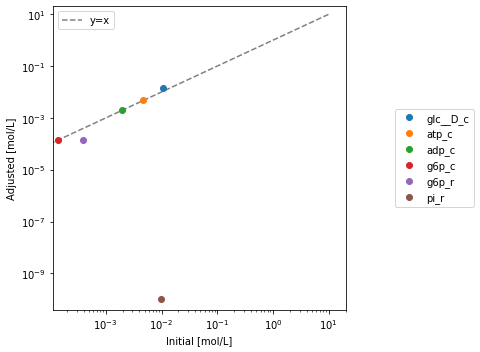

In [46]:
#Compare Results
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration(M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(0, 20), ylim=(0, 20), 
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    glycogenolysis, conc_solution, concentrations=True, inplace=True);

## Sample Concentrations

In [47]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycogenolysis.fixed),
    fixed_Keq_bounds=glycogenolysis.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = glycogenolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=seed)
conc_samples.head()

,adp_c,atp_c,g6p_c,glc__D_c,glc__D_e,g6p_r,glc__D_r,h2o_r,pi_r
0,0.005261,0.007833,0.000283,0.026252,0.012035,0.000025,0.071359,5.557400e-09,3.007346e-11
1,0.014180,0.017773,0.000236,0.079493,0.004714,0.000023,0.216085,7.084821e-09,1.139515e-11
2,0.006181,0.003189,0.001113,0.089168,0.017677,0.000899,0.242384,8.960530e-10,5.051344e-11
3,0.010675,0.000673,0.000094,0.035067,0.001464,0.000052,0.095323,2.788620e-09,2.315632e-11
4,0.004188,0.001800,0.000430,0.017253,0.006928,0.000062,0.046897,1.639667e-09,3.301627e-11


## Set concentrations and balance models with pseudoreactions

In [48]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycogenolysis.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)
        
        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))
print(models_for_ensemble)

Number of models in ensemble: 20
[<MassModel Glycogenolysis_C0 at 0x7f8d97bb8880>, <MassModel Glycogenolysis_C1 at 0x7f8d97a00a90>, <MassModel Glycogenolysis_C2 at 0x7f8d97a008b0>, <MassModel Glycogenolysis_C3 at 0x7f8d9c775e50>, <MassModel Glycogenolysis_C4 at 0x7f8d9c1a1d30>, <MassModel Glycogenolysis_C5 at 0x7f8d9b5398e0>, <MassModel Glycogenolysis_C6 at 0x7f8d9aec8b20>, <MassModel Glycogenolysis_C7 at 0x7f8d9a9268e0>, <MassModel Glycogenolysis_C8 at 0x7f8d9c985520>, <MassModel Glycogenolysis_C9 at 0x7f8d993ad790>, <MassModel Glycogenolysis_C10 at 0x7f8d99257eb0>, <MassModel Glycogenolysis_C11 at 0x7f8d98171700>, <MassModel Glycogenolysis_C12 at 0x7f8d9c3f74c0>, <MassModel Glycogenolysis_C13 at 0x7f8d99d87520>, <MassModel Glycogenolysis_C14 at 0x7f8d98894670>, <MassModel Glycogenolysis_C15 at 0x7f8d98894370>, <MassModel Glycogenolysis_C16 at 0x7f8d99cdd4c0>, <MassModel Glycogenolysis_C17 at 0x7f8db55ee5e0>, <MassModel Glycogenolysis_C18 at 0x7f8d9d2c77c0>, <MassModel Glycogenolysis_

#### Ensure model is in steady state and export

In [49]:
## determine imbalances in the reduced network
fluxes = np.array(list(glycogenolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycogenolysis.S.dot(fluxes)

# Iterate through metabolites
for mid, imbalance in imbalanced_metabolites.iteritems():
    # Ignore balanced metabolites
    if imbalance == 0:
        continue
    # Get metabolite object
    met = glycogenolysis.metabolites.get_by_id(mid)

    # Add boundary reactions for imbalanced metabolites
    boundary_type = "sink"    
    # Add boundary reaction with imbalance as flux value
    boundary_reaction = glycogenolysis.add_boundary(
        mid, boundary_type, boundary_condition=met.ic)

    boundary_reaction.Keq = 1
    if imbalance < 0:
        boundary_reaction.reverse_stoichiometry(inplace=True)
        imbalance = -imbalance

    boundary_reaction.kf = imbalance / met.ic
    boundary_reaction.steady_state_flux = imbalance
    try:
        # Update PERCs
        glycogenolysis.calculate_PERCs(
            fluxes={
                r: v for r, v in glycogenolysis.steady_state_fluxes.items()
                if not r.boundary},
            update_reactions=True)
    except:
        print("Negative PERCs for {0}".format(new_model.id))
        continue

In [58]:
## balancing charges on reactions manually

glycogenolysis.metabolites.h_c.charge=1
glycogenolysis.metabolites.pi_r.charge=-2

In [52]:
glycogenolysis.reactions.G6PPer

Reaction identifier,G6PPer
Name,"Glucose-6-phosphate phosphatase, edoplasmic reticular"
Memory address,0x07f8db55afa90
Subsystem,Glycolysis/gluconeogenesis
Kinetic Reversibility,True
Stoichiometry,g6p_r + h2o_r <=> glc__D_r + pi_r D-Glucose 6-phosphate + H2O H2O <=> D-Glucose + Phosphate
GPR,57818_AT1 or 2538_AT1 or 92579_AT1
Bounds,"(0.0, 1000.0)"


In [57]:
glycogenolysis.metabolites.pi_r.charge

0

In [59]:
qcqa_model(glycogenolysis, parameters=True, concentrations=True,
          fluxes=True, superfluous=True, elemental=True)


╒══════════════════════════════════════════╕
│ MODEL ID: Glycogenolysis                 │
│ SIMULATABLE: True                        │
│ PARAMETERS NUMERICALY CONSISTENT: True   │
╞══════════════════════════════════════════╡
╘══════════════════════════════════════════╛


In [60]:
# Whether to print messages as loop occurs. 
verbose = False
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
tfinal = 1e4

sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

models_to_export = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models_for_ensemble:
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " first attempt failed.")
        # First attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 10, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " second attempt failed.")
        # Second attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 100, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " third attempt failed. Eliminating model.")
        # Third attempt was not successful, eliminate the model
        sim.remove_models(models=model, verbose=verbose)

ERROR: Error encountered trying to  <set gene id  for '2645_AT1'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.
ERROR: Error encountered trying to  <set gene id  for '6513_AT1'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.
ERROR: Error encountered trying to  <set gene id  for '2542_AT1'>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object invo

MassSimulationError: Could not load MassModel 'Glycogenolysis_C0'

In [63]:
glycogenolysis.genes.remove('2645_AT1')
glycogenolysis.genes.remove('6513_AT1')
glycogenolysis.genes.remove('2542_AT1')
glycogenolysis.genes.remove('2538_AT1')

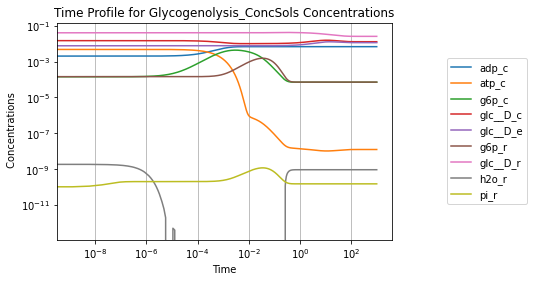

In [64]:
###RUN THIS FOR TIME PROFILE
# Setup simulation object
sim = Simulation(glycogenolysis, verbose=False)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycogenolysis, time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

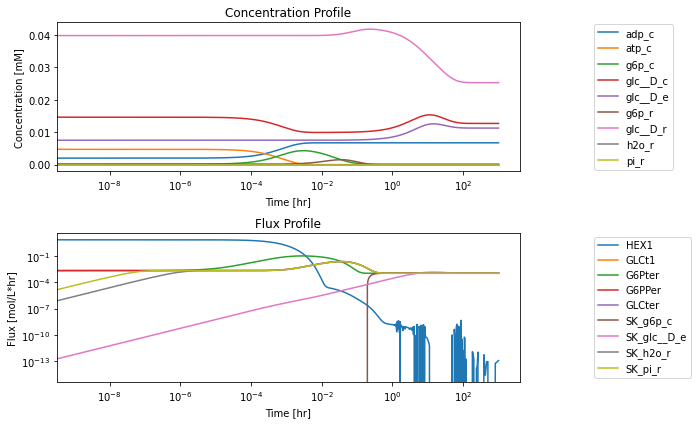

In [72]:
fig_1, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()
L_FONT = {"size": "large"}
plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    plot_function="semilogx",
    xlabel="Time [hr]", ylabel="Concentration [mM]",
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function='loglog',
    xlabel="Time [hr]", ylabel="Flux [mol/L*hr]",
    title=("Flux Profile", L_FONT));
fig_1.tight_layout()

